# Reading May and Beg. of June Data

In [1]:
%matplotlib inline
#from matplotlib import pyplot as pt
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns

import numpy as np

from datetime import datetime, timedelta

import os
import glob

TIME_INTERVAL = '4H'

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data-gala/*.txt')
    all_files = glob.glob(csv_path)
    
    all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
    
  #  print 'reading data from files:'
  #  for f in all_files:
  #      print f
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
#data.head()


got 1152582 rows total.


# Transforming data: creating datetime, entries and exits diffs, and sums

In [5]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.tail(2)

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
191730  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/05/2015   
191731  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT  06/05/2015   

            TIME     DESC  ENTRIES  EXITS            DATETIME  
191730  17:00:00  REGULAR     5554    212 2015-06-05 17:00:00  
191731  21:00:00  REGULAR     5554    212 2015-06-05 21:00:00

In [6]:
# Calclate new columns ENTRIES_DIFF and EXITS_DIFF for each unique turnstile/device.
# The first entry is NaN, the rest of the entries are the difference from the previous.
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])
for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)
data.head(3)

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
0  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  04/25/2015   
1  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  04/25/2015   
2  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  04/25/2015   

       TIME     DESC  ENTRIES    EXITS            DATETIME  ENTRIES_DIFF  \
0  00:00:00  REGULAR  5106770  1729635 2015-04-25 00:00:00           NaN   
1  04:00:00  REGULAR  5106810  1729649 2015-04-25 04:00:00          40.0   
2  08:00:00  REGULAR  5106835  1729680 2015-04-25 08:00:00          25.0   

   EXITS_DIFF  
0         NaN  
1        14.0  
2        31.0

In [7]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4568 4568


In [8]:
# learning how to deal with NA values
print len(data[data.ENTRIES_DIFF.isnull()])
print len(data.dropna())
print len(data)

4568
1148014
1152582


In [9]:
# dropping NA values and all non-REGULAR recordings
# calculating percentage of "regular" values vs. all nonNA values
reg_data = data.dropna()
reg_data = reg_data[ reg_data['DESC'] == 'REGULAR']
print len(reg_data)/float(len(data.dropna()))
#print reg_data.describe()

0.996898121451


In [10]:
# FYI: there are about 48% of rows that are recorded at times other than 0,4,8,12,16 or 20 hours !!! 
#times_4h = ['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00']
#filtered_times = reg_data[ reg_data['APPROXTIME'].isin(times_4h)]
#print filtered_times['TIME'].unique()
#print reg_data['TIME'].unique()
#print (len(reg_data)-len(filtered_times))/float(len(reg_data))

# Dealing with 4-h timestamps

In [12]:
#print reg_data.head()
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','LINENAME','DATETIME','DATE','TIME'], as_index=False)
station_period_totals = station_time_groupby[['ENTRIES_DIFF', 'EXITS_DIFF']].sum()
rounded_times = station_period_totals.set_index('DATETIME').groupby(['STATION','LINENAME'])
rounded_times = rounded_times.resample(TIME_INTERVAL,convention='end').sum()
print len(station_period_totals), len(rounded_times)
station_of_interest = '1 AVE'
print station_of_interest
print 'len before rounding:'
print len(station_period_totals[station_period_totals.STATION == station_of_interest])
print 'len after rounding:'
print len(rounded_times.loc[station_of_interest])
rounded_times = rounded_times.reset_index()
print rounded_times.head()

182442 118042
1 AVE
len before rounding:
257
len after rounding:
251
  STATION LINENAME            DATETIME  ENTRIES_DIFF  EXITS_DIFF
0   1 AVE        L 2015-04-25 04:00:00           3.0        76.0
1   1 AVE        L 2015-04-25 08:00:00           2.0        53.0
2   1 AVE        L 2015-04-25 12:00:00           2.0        54.0
3   1 AVE        L 2015-04-25 16:00:00           4.0        57.0
4   1 AVE        L 2015-04-25 20:00:00           0.0        41.0


# Finding Max Entries Stations

In [69]:
top_20_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_20_entries = top_20_entries.groupby(['STATION','LINENAME'])
top_20_entries = top_20_entries['ENTRIES_DIFF'].sum().sort_values(ascending=0)
top_20_entries = top_20_entries[:20]
print top_20_entries

STATION          LINENAME   
42 ST-GRD CNTRL  4567S          5421175.0
34 ST-HERALD SQ  BDFMNQR        4359345.0
42 ST-TIMES SQ   1237ACENQRS    3285044.0
34 ST-PENN STA   ACE            3088817.0
14 ST-UNION SQ   LNQR456        2776875.0
42 ST-PA BUS TE  ACENQRS1237    2608607.0
86 ST            456            2542337.0
59 ST-COLUMBUS   ABCD1          2274714.0
MAIN ST          7              2267407.0
47-50 ST-ROCK    BDFM           2102758.0
34 ST-PENN STA   123ACE         2007933.0
ROOSEVELT AVE    EFMR7          1922060.0
59 ST            456NQR         1919109.0
CANAL ST         JNQRZ6         1787151.0
W 4 ST-WASH SQ   ABCDEFM        1721922.0
72 ST            123            1635258.0
96 ST            123            1633039.0
PATH WTC         1              1627036.0
JAMAICA CENTER   EJZ            1551407.0
149 ST-GR CONC   245            1483969.0
Name: ENTRIES_DIFF, dtype: float64


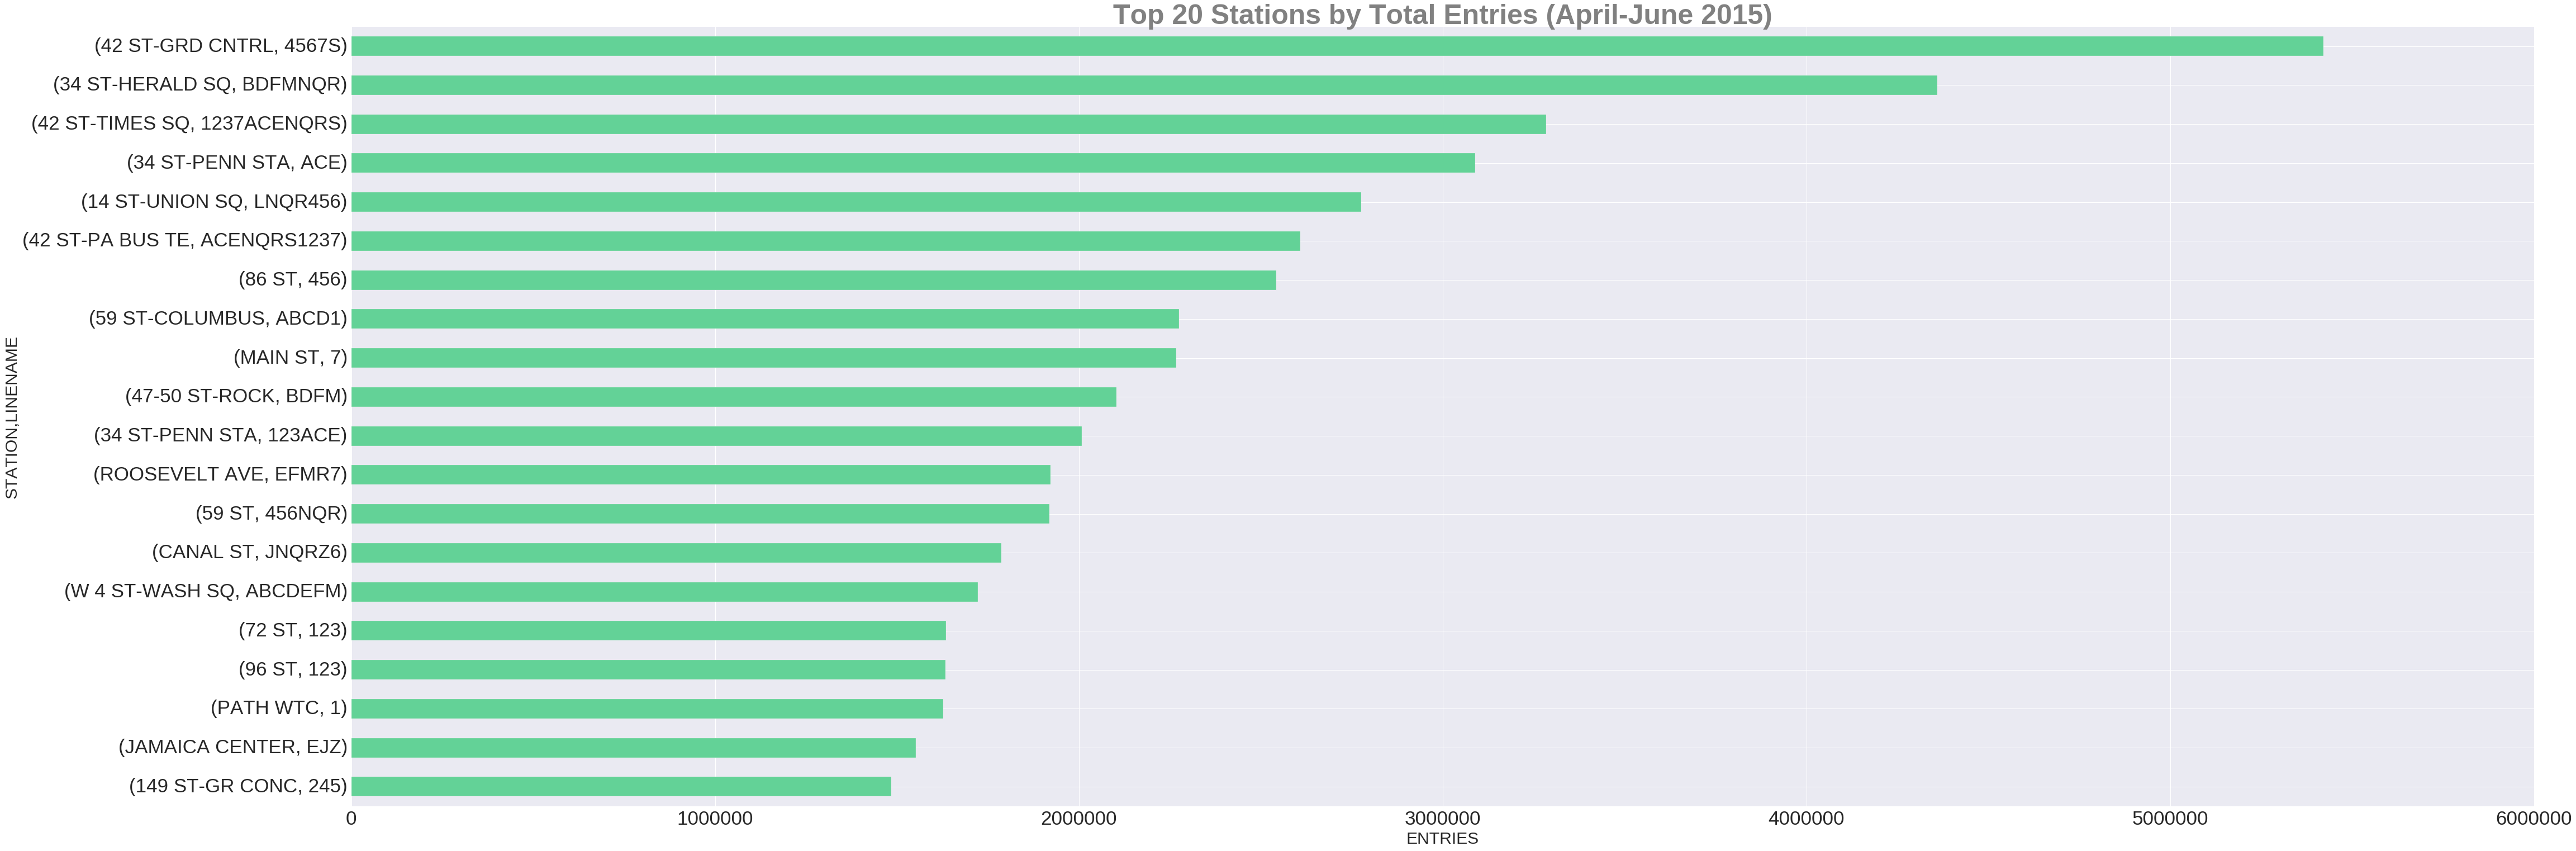

In [76]:
matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35) 
plt.figure(figsize = (70,25))
plt.title('Top 20 Stations by Total Entries (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('ENTRIES',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_entries.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
path = "entries/top_20_entries_lines_stations.png"
plt.savefig(path)

# Station Entries Day Time Heatmap - Top 50 Stations

In [59]:
# Removing outsiders -- error readings
data_dt_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
data_dt_entries['STATION_LINE'] = data_dt_entries['STATION'] + ", " + data_dt_entries['LINENAME']
data_dt_entries = data_dt_entries[['STATION_LINE', 'DATETIME', 'ENTRIES_DIFF']]
#print data_dt_entries.describe()
data_dt_entries['DAY'] = data_dt_entries['DATETIME'].dt.dayofweek
data_dt_entries['TIME'] = data_dt_entries['DATETIME'].dt.time
data_dt_entries.head(2)

/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


STATION_LINE            DATETIME  ENTRIES_DIFF  DAY      TIME
0     1 AVE, L 2015-04-25 04:00:00           3.0    5  04:00:00
1     1 AVE, L 2015-04-25 08:00:00           2.0    5  08:00:00

In [60]:
# Calculating average entries per station/line per day and time
stations_dt_entries = data_dt_entries.groupby(['STATION_LINE','DAY','TIME'])
stations_dt_entries = stations_dt_entries['ENTRIES_DIFF'].mean().reset_index()
stations_dt_entries.head(7)

STATION_LINE  DAY      TIME  ENTRIES_DIFF
0     1 AVE, L    0  00:00:00    846.000000
1     1 AVE, L    0  04:00:00    381.666667
2     1 AVE, L    0  08:00:00   1450.333333
3     1 AVE, L    0  12:00:00   4828.000000
4     1 AVE, L    0  16:00:00   4641.666667
5     1 AVE, L    0  20:00:00   6295.000000
6     1 AVE, L    1  00:00:00   3126.666667

In [67]:
# Saving top 100 stations by entries
top_100_entries = data_dt_entries.groupby('STATION_LINE')
top_100_entries = top_100_entries['ENTRIES_DIFF'].sum().sort_values(ascending=False)[:100].reset_index()
top_100_stations_entries = top_100_entries['STATION_LINE']
#print top_100_entries[:4]
print top_100_stations_entries[:4]

0         42 ST-GRD CNTRL, 4567S
1       34 ST-HERALD SQ, BDFMNQR
2    42 ST-TIMES SQ, 1237ACENQRS
3            34 ST-PENN STA, ACE
Name: STATION_LINE, dtype: object


42 ST-GRD CNTRL, 4567S
34 ST-HERALD SQ, BDFMNQR
42 ST-TIMES SQ, 1237ACENQRS
34 ST-PENN STA, ACE
14 ST-UNION SQ, LNQR456
42 ST-PA BUS TE, ACENQRS1237
86 ST, 456
59 ST-COLUMBUS, ABCD1
MAIN ST, 7
47-50 ST-ROCK, BDFM
34 ST-PENN STA, 123ACE
ROOSEVELT AVE, EFMR7
59 ST, 456NQR
CANAL ST, JNQRZ6
W 4 ST-WASH SQ, ABCDEFM
72 ST, 123
96 ST, 123
PATH WTC, 1
JAMAICA CENTER, EJZ
149 ST-GR CONC, 245
42 ST-BRYANT PK, BDFM7
JAY ST-METROTEC, ACF
FULTON ST, 2345ACJZ
LEXINGTON-53 ST, EM6
CHAMBERS ST, ACE23
14 ST-UNION SQ, 456LNQR
BOROUGH HALL/CT, 2345R
34 ST-PENN STA, 123
77 ST, 6
JOURNAL SQUARE, 1
68ST-HUNTER COL, 6
125 ST, ACBD
BOWLING GREEN, 45
9TH STREET, 1
FULTON ST, ACJZ2345
33 ST, 6
JFK JAMAICA CT1, E
CROWN HTS-UTICA, 34
FOREST HILLS-71, EFMR
96 ST, 6
8 AVE, ACEL
UNION TPK-KEW G, EF
23 ST-5 AVE, NR
GRAND ST, BD
145 ST, ABCD
50 ST, 1
SUTPHIN BLVD, EJZ
23 ST, 6
23 ST, CE
BROADWAY/LAFAY, BDFQ6
66 ST-LINCOLN, 1
WALL ST, 23
49 ST-7 AVE, NQR
5 AVE-53 ST, EM
23 ST-6 AVE, FM
WOODHAVEN BLVD, MR
THIRTY THIRD S

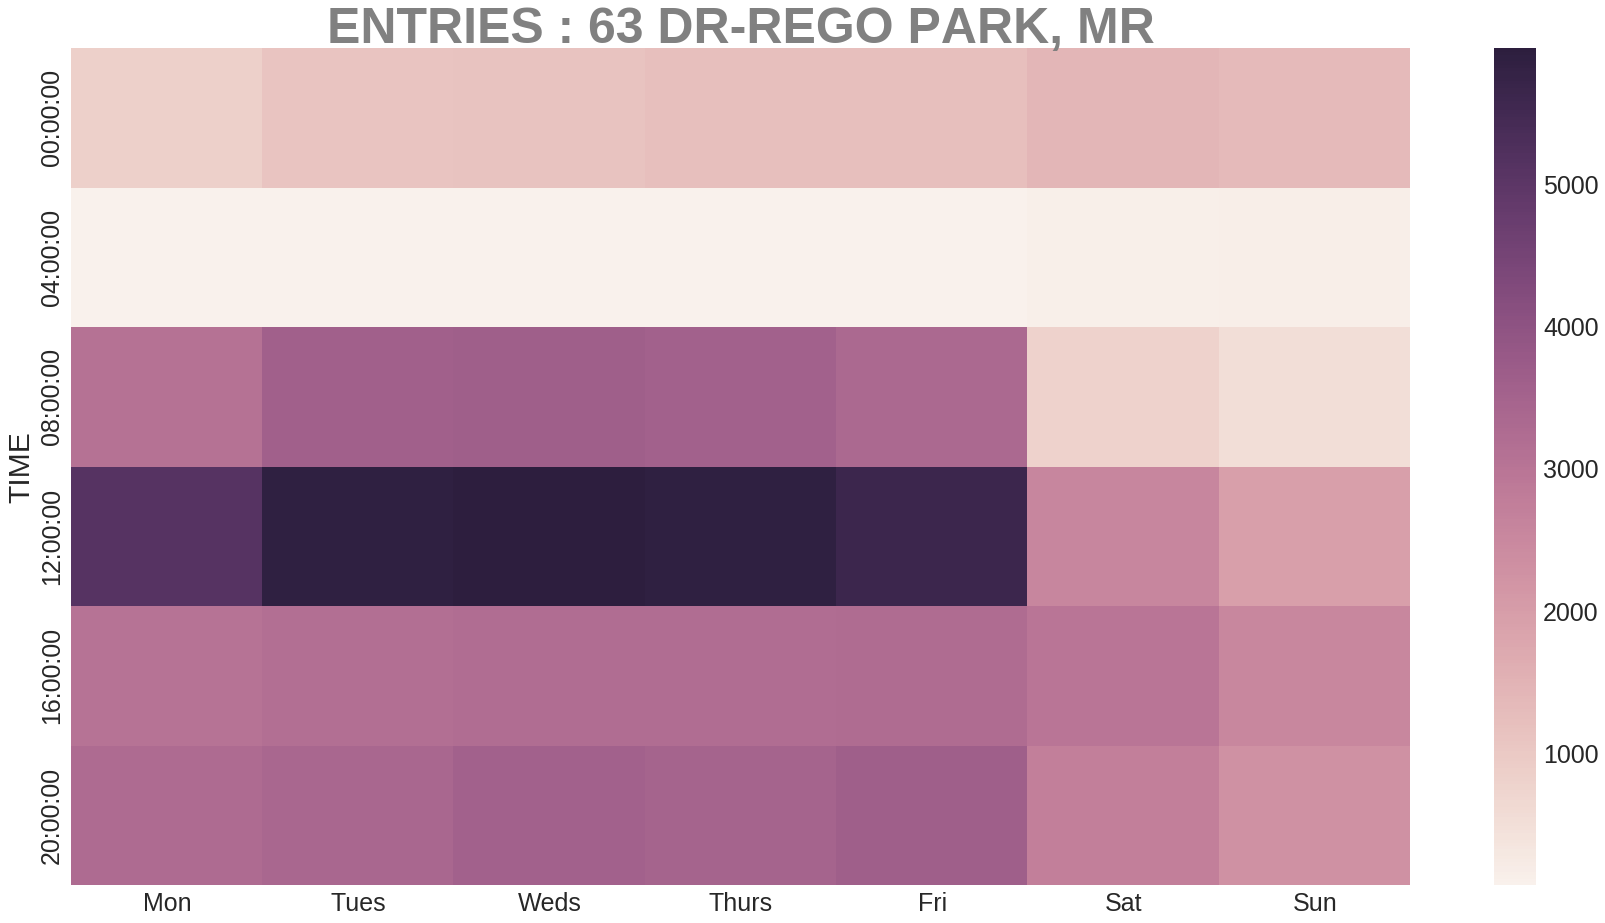

In [66]:
#for station in ['34 ST-PENN STA, ACE']:
for station in top_100_stations_entries:
    print station
    one_station = stations_dt_entries[ stations_dt_entries['STATION_LINE'] == station ]
    # changing format of the pandas data frame from three-columns to 2-column indices and third-column 
    # as values of a matrix
    one_dt_heatmap = one_station.set_index(['DAY', 'TIME']).ENTRIES_DIFF.unstack(0)
    days_mapper = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    one_dt_heatmap.columns = [days_mapper[c] for c in one_dt_heatmap.columns]
    plt.clf()
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.figure(figsize = (30,15))
    plt.title('ENTRIES : ' + station, fontsize=50, color='grey', fontweight='bold')
    plt.xlabel('DAY',fontsize=30)
    plt.ylabel('TIME',fontsize=30)
    sns.heatmap(one_dt_heatmap)
    stationpath = station
    stationdict = {'BOROUGH HALL/CT, 2345R': 'BOROUGH HALL-CT, 2345R',
                   'BROADWAY/LAFAY, BDFQ6' : 'BROADWAY-LAFAY, BDFQ6',
                   'PAVONIA/NEWPORT, 1' : 'PAVONIA-NEWPORT, 1',
                   '61 ST/WOODSIDE, 7' : '61 ST-WOODSIDE, 7'}
    if station in stationdict:
        stationpath = stationdict[station]
    path = "entries/heatmap_" + stationpath + ".png"
    plt.savefig(path)

# Finding Max Exits Stations

In [73]:
top_20_exits = rounded_times[ (rounded_times['EXITS_DIFF'] >= 0) & (rounded_times['EXITS_DIFF'] < 1000000)]
top_20_exits = top_20_exits.groupby(['STATION','LINENAME'])
top_20_exits = top_20_exits['EXITS_DIFF'].sum().sort_values(ascending=0)
top_20_exits = top_20_exits[:20]
print top_20_exits

STATION          LINENAME   
42 ST-GRD CNTRL  4567S          5054367.0
34 ST-HERALD SQ  BDFMNQR        4116555.0
34 ST-PENN STA   ACE            2824463.0
42 ST-TIMES SQ   1237ACENQRS    2750291.0
14 ST-UNION SQ   LNQR456        2438597.0
42 ST-PA BUS TE  ACENQRS1237    2312627.0
47-50 ST-ROCK    BDFM           2174243.0
86 ST            456            2168415.0
MAIN ST          7              1887297.0
59 ST-COLUMBUS   ABCD1          1803936.0
59 ST            456NQR         1705889.0
PATH WTC         1              1700561.0
LEXINGTON-53 ST  EM6            1657666.0
W 4 ST-WASH SQ   ABCDEFM        1655868.0
FULTON ST        2345ACJZ       1586644.0
96 ST            123            1545123.0
ROOSEVELT AVE    EFMR7          1515332.0
34 ST-PENN STA   123ACE         1426732.0
42 ST-BRYANT PK  BDFM7          1409885.0
CANAL ST         JNQRZ6         1308125.0
Name: EXITS_DIFF, dtype: float64


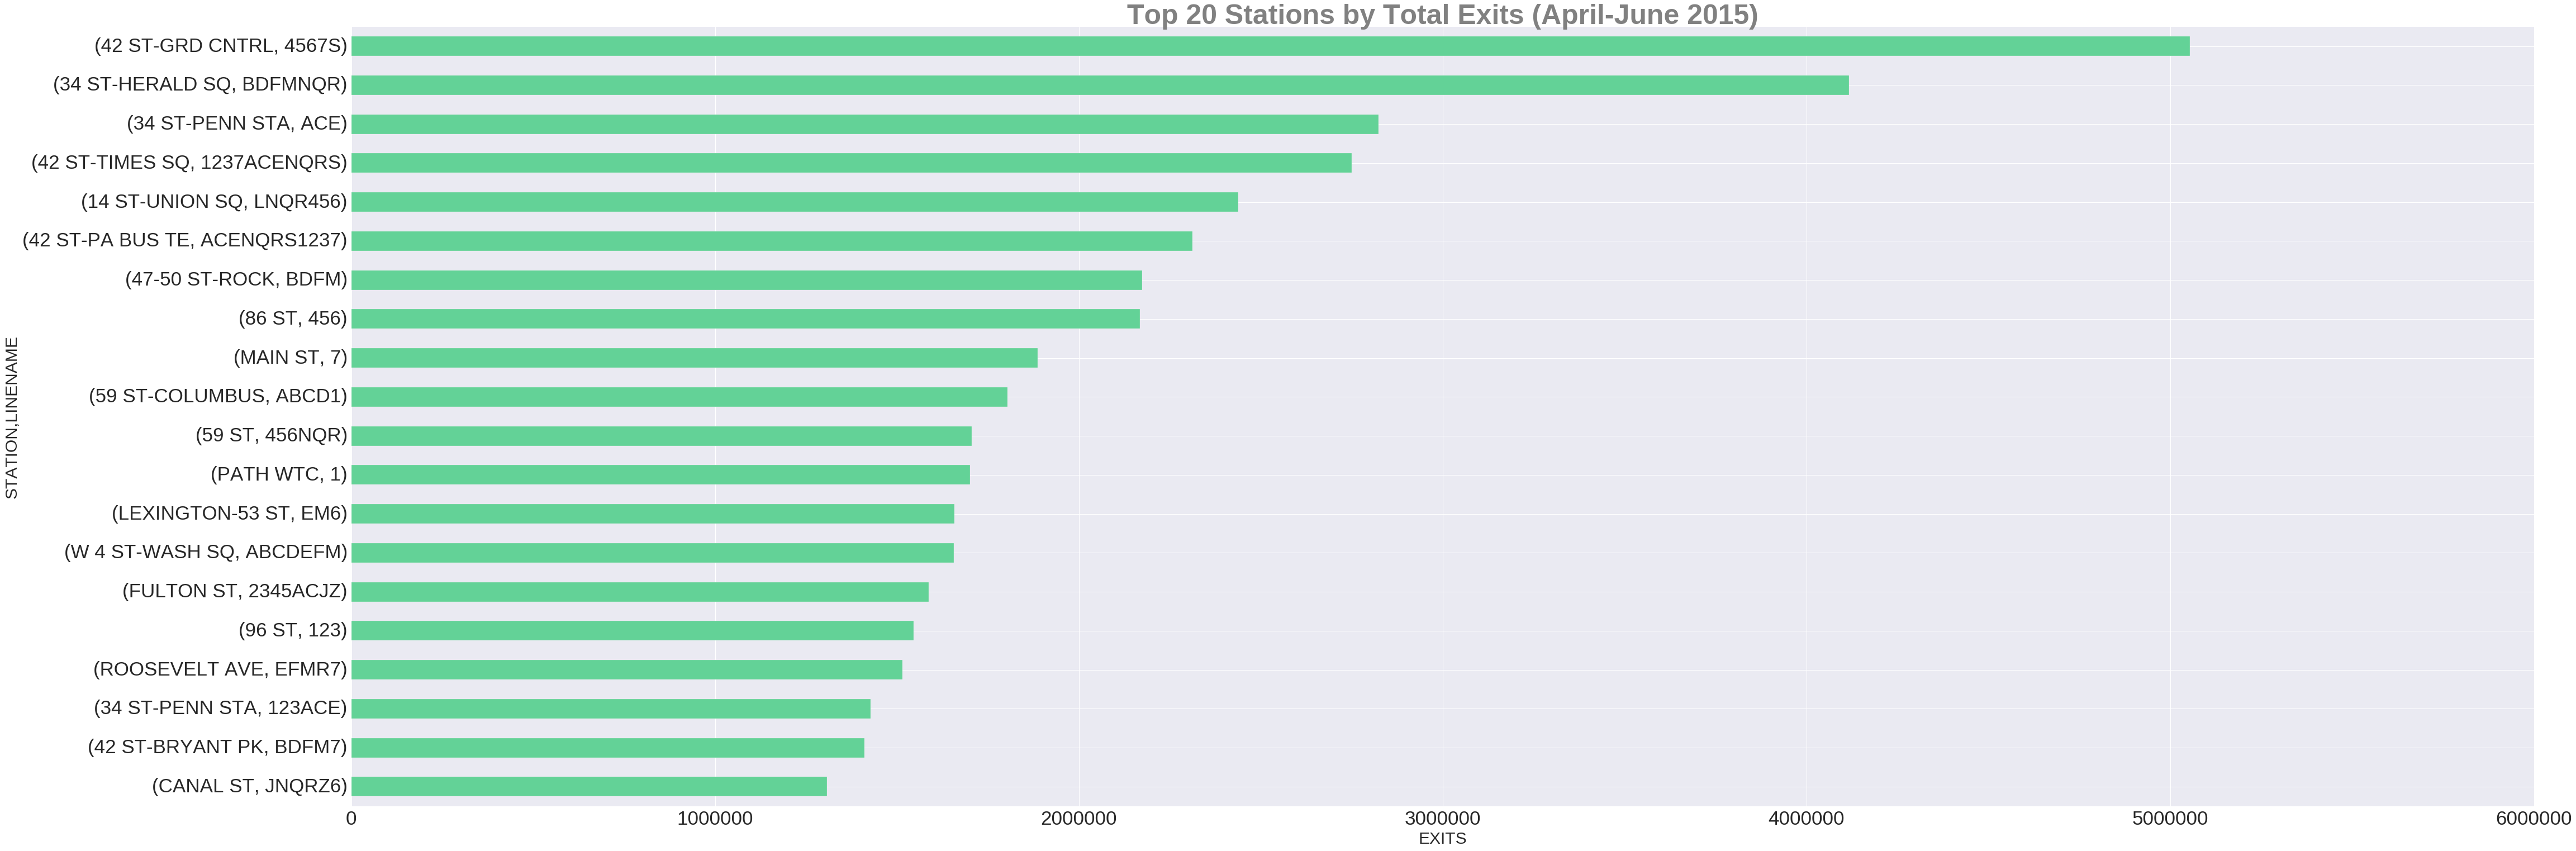

In [81]:
matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35) 
plt.figure(figsize = (70,25))
plt.title('Top 20 Stations by Total Exits (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('EXITS',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_exits.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
path = "exits/top_20_exits_lines_stations.png"
plt.savefig(path)

# Station Exits Day Time Heatmap - Top 50 Stations

In [78]:
# Removing outsiders -- error readings
data_dt_exits = rounded_times[ (rounded_times['EXITS_DIFF'] >= 0) & (rounded_times['EXITS_DIFF'] < 1000000)]
data_dt_exits['STATION_LINE'] = data_dt_exits['STATION'] + ", " + data_dt_exits['LINENAME']
data_dt_exits = data_dt_exits[['STATION_LINE', 'DATETIME', 'EXITS_DIFF']]
data_dt_exits['DAY'] = data_dt_exits['DATETIME'].dt.dayofweek
data_dt_exits['TIME'] = data_dt_exits['DATETIME'].dt.time
data_dt_exits.head(2)

/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


STATION_LINE            DATETIME  EXITS_DIFF  DAY      TIME
0     1 AVE, L 2015-04-25 04:00:00        76.0    5  04:00:00
1     1 AVE, L 2015-04-25 08:00:00        53.0    5  08:00:00

In [79]:
# Calculating average entries per station/line per day and time
stations_dt_exits = data_dt_exits.groupby(['STATION_LINE','DAY','TIME'])
stations_dt_exits = stations_dt_exits['EXITS_DIFF'].mean().reset_index()
stations_dt_exits.head(7)

STATION_LINE  DAY      TIME   EXITS_DIFF
0     1 AVE, L    0  00:00:00   976.833333
1     1 AVE, L    0  04:00:00   399.666667
2     1 AVE, L    0  08:00:00  2681.000000
3     1 AVE, L    0  12:00:00  5285.166667
4     1 AVE, L    0  16:00:00  4036.500000
5     1 AVE, L    0  20:00:00  6307.333333
6     1 AVE, L    1  00:00:00  3323.666667

In [80]:
# Saving top 100 stations by exits
top_100_exits = data_dt_exits.groupby('STATION_LINE')
top_100_exits = top_100_exits['EXITS_DIFF'].sum().sort_values(ascending=False)[:100].reset_index()
top_100_stations_exits = top_100_exits['STATION_LINE']
#print top_100_entries[:4]
print top_100_stations_exits[:4]

0         42 ST-GRD CNTRL, 4567S
1       34 ST-HERALD SQ, BDFMNQR
2            34 ST-PENN STA, ACE
3    42 ST-TIMES SQ, 1237ACENQRS
Name: STATION_LINE, dtype: object


42 ST-GRD CNTRL, 4567S
34 ST-HERALD SQ, BDFMNQR
34 ST-PENN STA, ACE
42 ST-TIMES SQ, 1237ACENQRS
14 ST-UNION SQ, LNQR456
42 ST-PA BUS TE, ACENQRS1237
47-50 ST-ROCK, BDFM
86 ST, 456
MAIN ST, 7
59 ST-COLUMBUS, ABCD1
59 ST, 456NQR
PATH WTC, 1
LEXINGTON-53 ST, EM6
W 4 ST-WASH SQ, ABCDEFM
FULTON ST, 2345ACJZ
96 ST, 123
ROOSEVELT AVE, EFMR7
34 ST-PENN STA, 123ACE
42 ST-BRYANT PK, BDFM7
CANAL ST, JNQRZ6
34 ST-PENN STA, 123
14 ST-UNION SQ, 456LNQR
JAMAICA CENTER, EJZ
BROADWAY/LAFAY, BDFQ6
77 ST, 6
72 ST, 123
28 ST, 6
BOWLING GREEN, 45
UNION TPK-KEW G, EF
5 AVE-53 ST, EM
BEDFORD AVE, L
125 ST, ACBD
125 ST, 456
JFK JAMAICA CT1, E
145 ST, ABCD
50 ST, 1
23 ST-6 AVE, FM
WALL ST, 23
BOROUGH HALL/CT, 2345R
BARCLAYS CENTER, BDNQR2345
33 ST, 6
23 ST, 6
JAY ST-METROTEC, ACF
66 ST-LINCOLN, 1
14 ST-6 AVE, FLM123
68ST-HUNTER COL, 6
CROWN HTS-UTICA, 34
1 AVE, L
49 ST-7 AVE, NQR
SUTPHIN BLVD, EJZ
14 ST, ACEL
8 AVE, ACEL
JUNCTION BLVD, 7
86 ST, 1
THIRTY THIRD ST, 1
CHAMBERS ST, 123
BROOKLYN BRIDGE, 456JZ
CHAMB

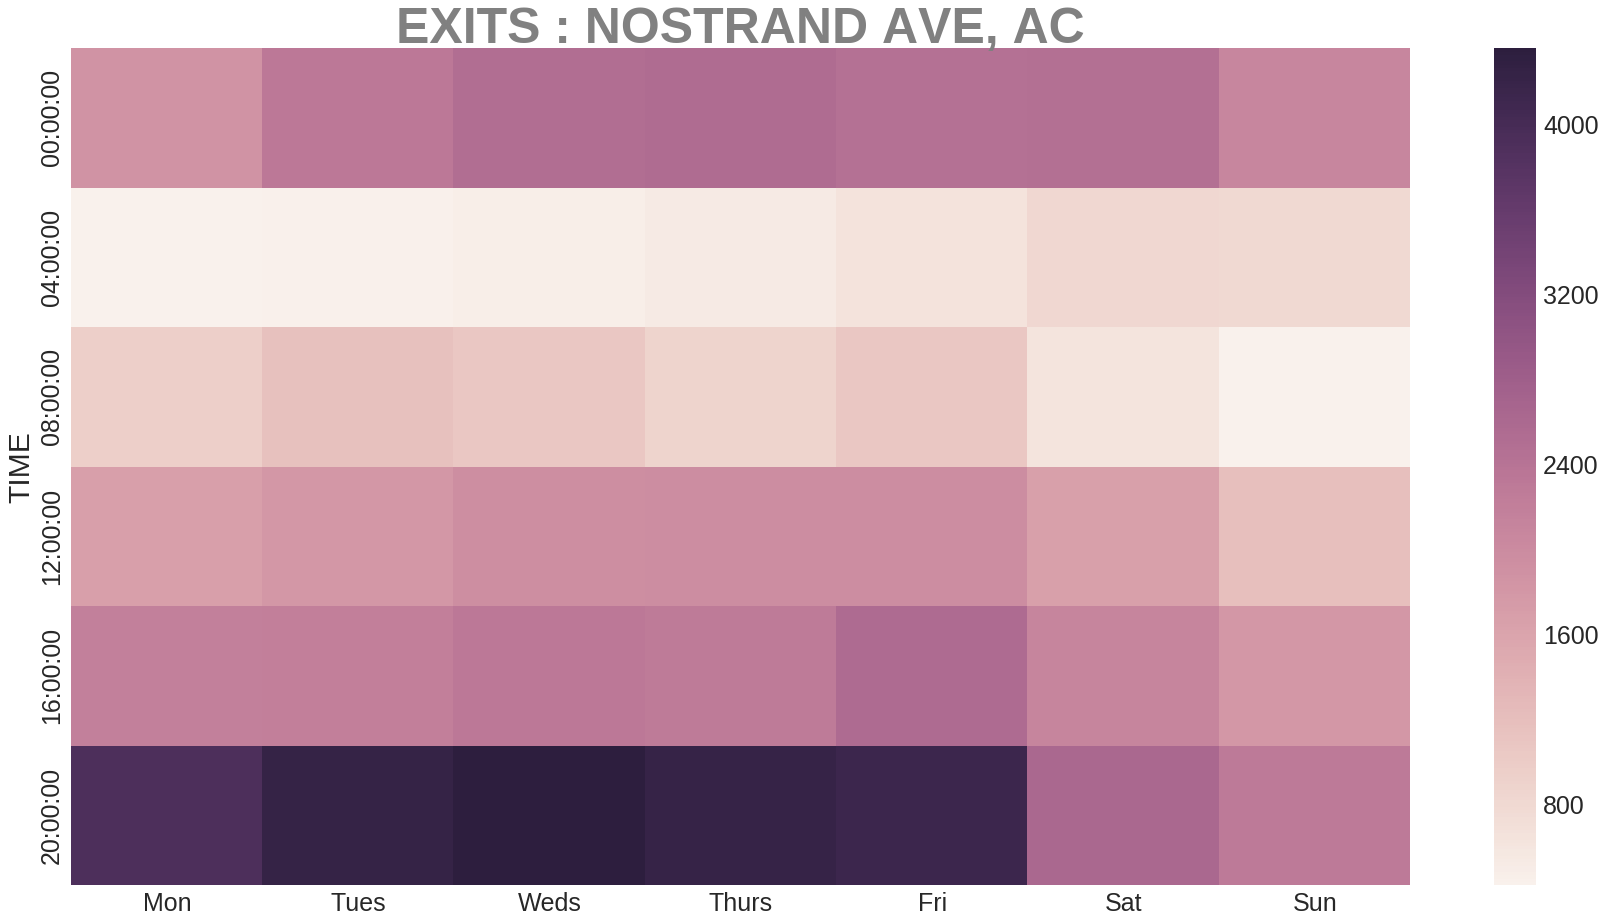

In [83]:
#for station in ['34 ST-PENN STA, ACE']:
for station in top_100_stations_exits:
    print station
    one_station = stations_dt_exits[ stations_dt_exits['STATION_LINE'] == station ]
    # changing format of the pandas data frame from three-columns to 2-column indices and third-column 
    # as values of a matrix
    one_dt_heatmap = one_station.set_index(['DAY', 'TIME']).EXITS_DIFF.unstack(0)
    days_mapper = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    one_dt_heatmap.columns = [days_mapper[c] for c in one_dt_heatmap.columns]
    plt.clf()
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.figure(figsize = (30,15))
    plt.title('EXITS : ' + station, fontsize=50, color='grey', fontweight='bold')
    plt.xlabel('DAY',fontsize=30)
    plt.ylabel('TIME',fontsize=30)
    sns.heatmap(one_dt_heatmap)
    stationpath = station
    stationdict = {'BOROUGH HALL/CT, 2345R': 'BOROUGH HALL-CT, 2345R',
                   'BROADWAY/LAFAY, BDFQ6' : 'BROADWAY-LAFAY, BDFQ6',
                   'PAVONIA/NEWPORT, 1' : 'PAVONIA-NEWPORT, 1',
                   '61 ST/WOODSIDE, 7' : '61 ST-WOODSIDE, 7',
                   'CITY / BUS, 1' : 'CITY-BUS, 1'}
    if station in stationdict:
        stationpath = stationdict[station]
    path = "exits/heatmap_" + stationpath + ".png"
    plt.savefig(path)